In [ ]:
import warnings
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from datasets import Dataset
from transformers import AdamW, XLMRobertaTokenizerFast, XLMRobertaForTokenClassification, DataCollatorForTokenClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from seqeval.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

warnings.filterwarnings("ignore")

c:\coding\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##### General set up

In [3]:
tokenizer = XLMRobertaTokenizerFast.from_pretrained("xlm-roberta-base")

In [4]:
cultural_train = "data/train_merged_output_cultural1.conll"
# cultural_train = "annotation/test/fully_annotated_span_test_lyrics.conll"
cultural_test = "data/test_merged_output_cultural1.conll"
# cultural_test = "annotation/train/fully_annotated_lyrics_span.conll"

In [5]:
def extract_refs(json_path):
    cultural_refs_tag = []
    cultural_refs_IDs = {}

    with open(json_path, "r") as f:
        cultural_data = json.load(f)
        cultural_refs_tag.extend([entry['tag'] for entry in cultural_data])
        cultural_refs_IDs.update({entry['tag']: entry['id'] for entry in cultural_data})

    return cultural_refs_tag, cultural_refs_IDs

ner_tags_path = "data/ner_tags.json"
cultural_ref_tags_path = "data/cultural_tags.json"

ner_tags, tag2id_ner = extract_refs(ner_tags_path)
cultural_tags, tag2id_cultural = extract_refs(cultural_ref_tags_path)

num_labels_culture = len(tag2id_cultural)
num_labels_ner = len(tag2id_ner)

id2tag_ner = {v: k for k, v in tag2id_ner.items()}
id2tag_cultural = {v: k for k, v in tag2id_cultural.items()}

In [6]:
# if torch.cuda.is_available():
#     device = torch.device("cuda")    
#     print('There are %d GPU(s) available.' % torch.cuda.device_count())
#     print('GPU is:', torch.cuda.get_device_name(0))
# else:
#     print('No GPU available, using the CPU instead.')
#     device = torch.device("cpu")

##### Vizualizations

In [7]:
header = {0:'token', 1:'ner_tag', 2:'cultural_tag'}

chunksize = 100000
chunks = []  # List to store chunks

In [8]:
chunks = pd.read_csv(
    cultural_train,
    encoding='utf-8',
    sep='\t',
    engine='python',
    on_bad_lines='skip',
    header=None,
    quoting=csv.QUOTE_NONE,
    chunksize=100000,
    low_memory=True
)


In [9]:
chunks_test = pd.read_csv(
    cultural_test,
    encoding='utf-8',
    sep='\t',
    engine='python',
    on_bad_lines='skip',
    header=None,
    quoting=csv.QUOTE_NONE,
    chunksize=100000,
    low_memory=True
)


In [10]:
df = pd.concat(chunks, ignore_index=True)

In [11]:
df_test = pd.concat(chunks_test, ignore_index=True)

In [12]:
exclude = ['-']
filtered_cult = df[~df[2].isin(exclude)]

In [13]:
filtered_cult_test = df_test[~df_test[2].isin(exclude)]

<AxesSubplot: xlabel='2'>

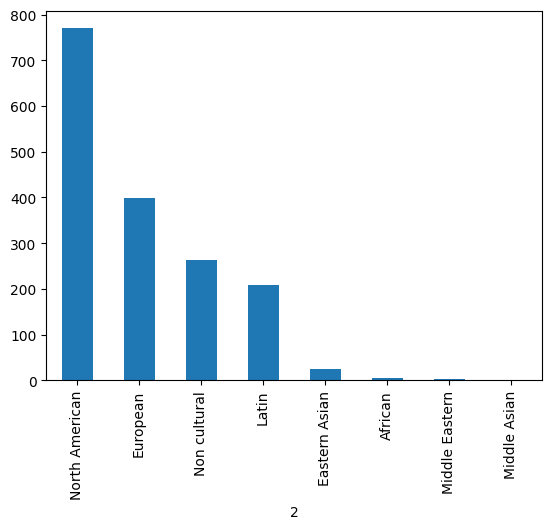

In [14]:
filtered_cult[2].value_counts().plot.bar()
#imbalanced data for training

<AxesSubplot: xlabel='2'>

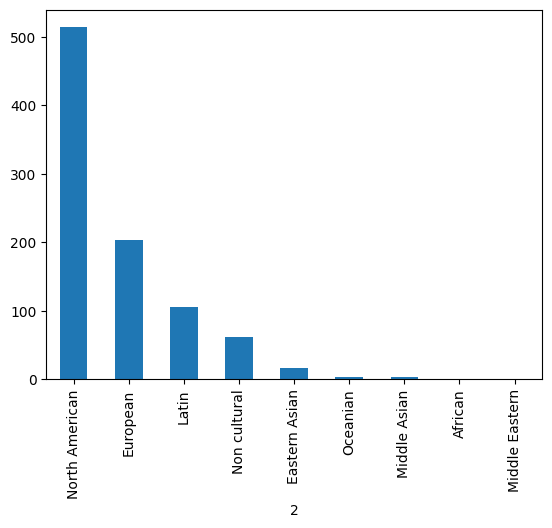

In [15]:
filtered_cult_test[2].value_counts().plot.bar()
#imbalanced data for test

#### Data aligment

In [16]:
def parse_conllu(file_path):
    " This function create a usable dataset of the sparse .conllu file with the NER tags and cultural refferences"
    sentences = []
    tags = []
    cultural_references = []
    
    with open(file_path, "r",encoding="utf-8") as file:
        tokens = []
        ner_tags = []
        cultural_ref = []
        
        for line in file:
            line = line.strip()
                       
            if not line:
                if tokens:  
                    sentences.append(tokens)
                    tags.append(ner_tags)
                    cultural_references.append(cultural_ref)
              
                tokens = []
                ner_tags = []
                cultural_ref = []
                continue

            parts = line.split("\t")
            
            if len(parts) >= 3:
                token = parts[0]  
                ner_tag = parts[1] 
                cultural_ref_val = parts[2]
                
                tokens.append(token)
                ner_tags.append(ner_tag)
                cultural_ref.append(cultural_ref_val)
        
       
        if tokens:
            sentences.append(tokens)
            tags.append(ner_tags)
            cultural_references.append(cultural_ref)
    
    return sentences, tags, cultural_references

In [17]:
sentences, tags, cultural_refs = parse_conllu(cultural_train)
train_data = [{"tokens": s, "ner_tags": t, "cultural_ref": c} for s, t, c in zip(sentences, tags, cultural_refs)]
dataset_train = Dataset.from_list(train_data)

In [18]:
#load test data for later use:
sentences_test, tags_test, cultural_refs_test = parse_conllu(cultural_test)
test_data = [{"tokens": s, "ner_tags": t, "cultural_ref": c} for s, t, c in zip(sentences_test, tags_test, cultural_refs_test)]
dataset_test = Dataset.from_list(test_data)

In [19]:
dataset = dataset_train.train_test_split(test_size=0.1, seed=42)
train_dataset = dataset["train"]
val_dataset = dataset["test"]

In [20]:
train_dataset

Dataset({
    features: ['tokens', 'ner_tags', 'cultural_ref'],
    num_rows: 4803
})

In [21]:
def tokenize_and_align_labels_multitask(example):
    tokenized = tokenizer(
        example['tokens'],
        truncation=True,
        is_split_into_words=True,
        padding=True
    )

    labels_ner = []
    labels_cultural = []

    word_ids = tokenized.word_ids()
    previous_word_idx = None

    for word_idx in word_ids:
        if word_idx is None:
            labels_ner.append(-100)
            labels_cultural.append(-100)
        elif word_idx != previous_word_idx:
            ner_tag = example['ner_tags'][word_idx]
            cultural_tag = example['cultural_ref'][word_idx]

            labels_ner.append(tag2id_ner.get(ner_tag, -100))
            labels_cultural.append(tag2id_cultural.get(cultural_tag, -100))
        else:
            labels_ner.append(-100)
            labels_cultural.append(-100)

        previous_word_idx = word_idx

    tokenized['labels_ner'] = labels_ner
    tokenized['labels'] = labels_cultural

    return tokenized


In [ ]:
tokenized_cultural_train = train_dataset.map(tokenize_and_align_labels_multitask)
tokenized_cultural_val = val_dataset.map(tokenize_and_align_labels_multitask)
tokenized_cultural_test = dataset_test.map(tokenize_and_align_labels_multitask)

In [23]:
print(tokenized_cultural_train[7]['input_ids'])
print(tokenized_cultural_train[7]['labels'])
print(tokenized_cultural_train[7]['labels_ner'])


[0, 84415, 41537, 26, 7, 40960, 152, 45327, 6, 4, 23040, 6, 4, 87, 3444, 935, 14361, 6, 4, 87, 3444, 935, 14361, 6, 4, 242, 22304, 111, 450, 6957, 4998, 26, 19780, 20751, 6, 5, 45327, 6, 4, 23040, 6, 4, 87, 3444, 935, 14361, 6, 4, 87, 3444, 935, 14361, 6, 4, 242, 22304, 111, 450, 6957, 4998, 26, 19780, 20751, 2]
[-100, 8, -100, -100, -100, 0, 0, 0, 0, -100, 0, 0, -100, 0, 0, 0, 0, 0, -100, 0, 0, 0, 0, 0, -100, 0, 0, 0, 0, 0, 0, -100, 0, 0, 0, -100, 0, 0, -100, 0, 0, -100, 0, 0, 0, 0, 0, -100, 0, 0, 0, 0, 0, -100, 0, 0, 0, 0, 0, 0, -100, 0, 0, -100]
[-100, 3, -100, -100, -100, 8, 8, 8, 8, -100, 8, 8, -100, 8, 8, 8, 8, 8, -100, 8, 8, 8, 8, 8, -100, 8, 8, 8, 8, 8, 8, -100, 8, 8, 8, -100, 8, 8, -100, 8, 8, -100, 8, 8, 8, 8, 8, -100, 8, 8, 8, 8, 8, -100, 8, 8, 8, 8, 8, 8, -100, 8, 8, -100]


In [24]:
# Small dataset for testing
# small_train_data = tokenized_cultural_train.select(range(1000))

In [25]:
tokenized_cultural_train[7]

{'tokens': ['Kendrick’s',
  'Dad',
  ':',
  'Girl',
  ',',
  'girl',
  ',',
  'I',
  'want',
  'your',
  'body',
  ',',
  'I',
  'want',
  'your',
  'body',
  ',',
  "'",
  'cause',
  'of',
  'that',
  'big',
  'ol’',
  'fat',
  'ass',
  '.',
  'Girl',
  ',',
  'girl',
  ',',
  'I',
  'want',
  'your',
  'body',
  ',',
  'I',
  'want',
  'your',
  'body',
  ',',
  "'",
  'cause',
  'of',
  'that',
  'big',
  'ol’',
  'fat',
  'ass'],
 'ner_tags': ['B-PER',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 'cultural_ref': ['North American',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-'

In [26]:
for i in range(3):
    tokens = tokenizer.convert_ids_to_tokens(tokenized_cultural_train[i]['input_ids'])
    labels = [id2tag_cultural.get(id, "IGN") for id in tokenized_cultural_train[i]['labels']]
    print(list(zip(tokens, labels)))

[('<s>', 'IGN'), ('▁When', '-'), ('▁I', '-'), ('▁want', '-'), ('▁you', '-'), ('▁in', '-'), ('▁my', '-'), ('▁world', '-'), ('</s>', 'IGN')]
[('<s>', 'IGN'), ('▁I', '-'), ('▁got', '-'), ('▁the', '-'), ('▁love', '-'), ('▁bir', '-'), ('ds', 'IGN'), ('▁chi', '-'), ('r', 'IGN'), ('pin', 'IGN'), ("'", 'IGN'), ('▁at', '-'), ('▁the', '-'), ('▁window', '-'), ('</s>', 'IGN')]
[('<s>', 'IGN'), ('▁Cuando', '-'), ('▁te', '-'), ('▁lo', '-'), ('▁qui', '-'), ('to', 'IGN'), ('▁des', '-'), ('pu', 'IGN'), ('é', 'IGN'), ("'", 'IGN'), ('▁de', '-'), ('▁lo', '-'), ('▁partie', '-'), ("'", 'IGN'), ('</s>', 'IGN')]


#### Model set up

In [27]:
data_collator = DataCollatorForTokenClassification(tokenizer)

In [28]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [id2tag_cultural[p] for (p, l) in zip(pred, label) if l != -100]
        for pred, label in zip(predictions, labels)
    ]
    true_labels = [
        [id2tag_cultural[l] for (p, l) in zip(pred, label) if l != -100]
        for pred, label in zip(predictions, labels)
    ]

    return {
        "precision": precision_score(true_labels, true_predictions),
        "recall": recall_score(true_labels, true_predictions),
        "f1": f1_score(true_labels, true_predictions),
    }

##### Final model (ver3.)

In [29]:
model_classifier = XLMRobertaForTokenClassification.from_pretrained(
    "xlm-roberta-base",
    num_labels=num_labels_culture,
    id2label=id2tag_cultural,
    label2id=tag2id_cultural)

optimizer = AdamW(model_classifier.parameters(), lr=5e-5)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to us

In [44]:
training_args = TrainingArguments(
    output_dir="./models/xlmr-cultural-head",
    save_strategy="steps",
    save_steps=100,
    evaluation_strategy="steps",
    eval_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    logging_dir="./logs",
    logging_steps=50,
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    max_grad_norm=1.0,
    save_total_limit=2,
    remove_unused_columns=True,
    fp16=False,
)

trainer_classifier = Trainer(
    model=model_classifier,
    args=training_args,
    train_dataset=tokenized_cultural_train,
    eval_dataset=tokenized_cultural_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],)

##### Model training and evaluation

In [31]:
trainer_classifier.train()

  2%|▏         | 50/3010 [02:41<2:33:27,  3.11s/it]

{'loss': 0.4025, 'learning_rate': 2.9501661129568108e-05, 'epoch': 0.17}


  3%|▎         | 100/3010 [05:11<2:29:18,  3.08s/it]

{'loss': 0.1414, 'learning_rate': 2.9003322259136212e-05, 'epoch': 0.33}


                                                    
  3%|▎         | 100/3010 [05:22<2:29:18,  3.08s/it]

{'eval_loss': 0.16742804646492004, 'eval_precision': 0.25650557620817843, 'eval_recall': 0.21766561514195584, 'eval_f1': 0.2354948805460751, 'eval_runtime': 11.2083, 'eval_samples_per_second': 47.643, 'eval_steps_per_second': 3.033, 'epoch': 0.33}


  5%|▍         | 150/3010 [08:03<2:27:11,  3.09s/it]

{'loss': 0.1351, 'learning_rate': 2.850498338870432e-05, 'epoch': 0.5}


  7%|▋         | 200/3010 [10:40<2:44:18,  3.51s/it]

{'loss': 0.0806, 'learning_rate': 2.8006644518272427e-05, 'epoch': 0.66}


                                                    
  7%|▋         | 200/3010 [10:51<2:44:18,  3.51s/it]

{'eval_loss': 0.1251513957977295, 'eval_precision': 0.5261044176706827, 'eval_recall': 0.41324921135646686, 'eval_f1': 0.4628975265017668, 'eval_runtime': 11.1983, 'eval_samples_per_second': 47.686, 'eval_steps_per_second': 3.036, 'epoch': 0.66}


  8%|▊         | 250/3010 [13:36<2:12:32,  2.88s/it]

{'loss': 0.0994, 'learning_rate': 2.750830564784053e-05, 'epoch': 0.83}


 10%|▉         | 300/3010 [16:06<2:08:52,  2.85s/it]

{'loss': 0.1053, 'learning_rate': 2.700996677740864e-05, 'epoch': 1.0}


                                                    
 10%|▉         | 300/3010 [16:17<2:08:52,  2.85s/it]

{'eval_loss': 0.10526314377784729, 'eval_precision': 0.5616438356164384, 'eval_recall': 0.5173501577287066, 'eval_f1': 0.5385878489326766, 'eval_runtime': 11.2673, 'eval_samples_per_second': 47.394, 'eval_steps_per_second': 3.018, 'epoch': 1.0}


 12%|█▏        | 350/3010 [18:57<2:12:29,  2.99s/it]

{'loss': 0.0755, 'learning_rate': 2.6511627906976747e-05, 'epoch': 1.16}


 13%|█▎        | 400/3010 [21:34<2:21:34,  3.25s/it]

{'loss': 0.0796, 'learning_rate': 2.601328903654485e-05, 'epoch': 1.33}


                                                    
 13%|█▎        | 400/3010 [21:45<2:21:34,  3.25s/it]

{'eval_loss': 0.09747350215911865, 'eval_precision': 0.6134751773049646, 'eval_recall': 0.5457413249211357, 'eval_f1': 0.5776293823038398, 'eval_runtime': 11.0796, 'eval_samples_per_second': 48.197, 'eval_steps_per_second': 3.069, 'epoch': 1.33}


 15%|█▍        | 450/3010 [24:25<2:14:25,  3.15s/it]

{'loss': 0.0665, 'learning_rate': 2.5514950166112958e-05, 'epoch': 1.5}


 17%|█▋        | 500/3010 [26:57<2:09:32,  3.10s/it]

{'loss': 0.0658, 'learning_rate': 2.5016611295681066e-05, 'epoch': 1.66}


                                                    
 17%|█▋        | 500/3010 [27:08<2:09:32,  3.10s/it]

{'eval_loss': 0.1119973435997963, 'eval_precision': 0.6125, 'eval_recall': 0.4637223974763407, 'eval_f1': 0.5278276481149013, 'eval_runtime': 11.1165, 'eval_samples_per_second': 48.037, 'eval_steps_per_second': 3.059, 'epoch': 1.66}


 18%|█▊        | 550/3010 [29:45<1:57:41,  2.87s/it]

{'loss': 0.0875, 'learning_rate': 2.451827242524917e-05, 'epoch': 1.83}


 20%|█▉        | 600/3010 [32:20<2:04:26,  3.10s/it]

{'loss': 0.0554, 'learning_rate': 2.4019933554817277e-05, 'epoch': 1.99}


                                                    
 20%|█▉        | 600/3010 [32:31<2:04:26,  3.10s/it]

{'eval_loss': 0.08981933444738388, 'eval_precision': 0.6526717557251909, 'eval_recall': 0.5394321766561514, 'eval_f1': 0.5906735751295337, 'eval_runtime': 11.0285, 'eval_samples_per_second': 48.42, 'eval_steps_per_second': 3.083, 'epoch': 1.99}


 22%|██▏       | 650/3010 [35:09<2:06:42,  3.22s/it]

{'loss': 0.0535, 'learning_rate': 2.3521594684385385e-05, 'epoch': 2.16}


 23%|██▎       | 700/3010 [37:42<1:59:33,  3.11s/it]

{'loss': 0.0448, 'learning_rate': 2.302325581395349e-05, 'epoch': 2.33}


                                                    
 23%|██▎       | 700/3010 [37:54<1:59:33,  3.11s/it]

{'eval_loss': 0.09682697057723999, 'eval_precision': 0.6159695817490495, 'eval_recall': 0.5110410094637224, 'eval_f1': 0.5586206896551725, 'eval_runtime': 11.3067, 'eval_samples_per_second': 47.229, 'eval_steps_per_second': 3.007, 'epoch': 2.33}


 25%|██▍       | 750/3010 [40:36<1:57:38,  3.12s/it]

{'loss': 0.0543, 'learning_rate': 2.2524916943521596e-05, 'epoch': 2.49}


 27%|██▋       | 800/3010 [43:14<1:49:18,  2.97s/it]

{'loss': 0.0429, 'learning_rate': 2.2026578073089704e-05, 'epoch': 2.66}


                                                    
 27%|██▋       | 800/3010 [43:25<1:49:18,  2.97s/it]

{'eval_loss': 0.09699610620737076, 'eval_precision': 0.6517571884984026, 'eval_recall': 0.6435331230283912, 'eval_f1': 0.6476190476190476, 'eval_runtime': 11.2154, 'eval_samples_per_second': 47.613, 'eval_steps_per_second': 3.032, 'epoch': 2.66}


 28%|██▊       | 850/3010 [46:00<1:48:54,  3.03s/it]

{'loss': 0.045, 'learning_rate': 2.1528239202657808e-05, 'epoch': 2.82}


 30%|██▉       | 900/3010 [48:34<1:51:07,  3.16s/it]

{'loss': 0.0586, 'learning_rate': 2.1029900332225916e-05, 'epoch': 2.99}


                                                    
 30%|██▉       | 900/3010 [48:45<1:51:07,  3.16s/it]

{'eval_loss': 0.08729029446840286, 'eval_precision': 0.6759581881533101, 'eval_recall': 0.61198738170347, 'eval_f1': 0.642384105960265, 'eval_runtime': 11.1109, 'eval_samples_per_second': 48.061, 'eval_steps_per_second': 3.06, 'epoch': 2.99}


 32%|███▏      | 950/3010 [51:30<1:50:38,  3.22s/it]

{'loss': 0.0352, 'learning_rate': 2.0531561461794023e-05, 'epoch': 3.16}


 33%|███▎      | 1000/3010 [54:03<1:36:31,  2.88s/it]

{'loss': 0.0337, 'learning_rate': 2.0033222591362127e-05, 'epoch': 3.32}


                                                     
 33%|███▎      | 1000/3010 [54:14<1:36:31,  2.88s/it]

{'eval_loss': 0.10445798188447952, 'eval_precision': 0.6945454545454546, 'eval_recall': 0.6025236593059937, 'eval_f1': 0.6452702702702703, 'eval_runtime': 11.0288, 'eval_samples_per_second': 48.419, 'eval_steps_per_second': 3.083, 'epoch': 3.32}


 35%|███▍      | 1050/3010 [56:53<1:42:59,  3.15s/it]

{'loss': 0.033, 'learning_rate': 1.9534883720930235e-05, 'epoch': 3.49}


 37%|███▋      | 1100/3010 [59:19<1:32:33,  2.91s/it]

{'loss': 0.0316, 'learning_rate': 1.9036544850498342e-05, 'epoch': 3.65}


                                                     
 37%|███▋      | 1100/3010 [59:31<1:32:33,  2.91s/it]

{'eval_loss': 0.10620724409818649, 'eval_precision': 0.6590038314176245, 'eval_recall': 0.5425867507886435, 'eval_f1': 0.5951557093425606, 'eval_runtime': 11.2113, 'eval_samples_per_second': 47.63, 'eval_steps_per_second': 3.033, 'epoch': 3.65}


 38%|███▊      | 1150/3010 [1:02:11<1:33:05,  3.00s/it]

{'loss': 0.0342, 'learning_rate': 1.8538205980066446e-05, 'epoch': 3.82}


 40%|███▉      | 1200/3010 [1:04:45<1:30:56,  3.01s/it]

{'loss': 0.0346, 'learning_rate': 1.8039867109634554e-05, 'epoch': 3.99}


                                                       
 40%|███▉      | 1200/3010 [1:04:57<1:30:56,  3.01s/it]

{'eval_loss': 0.10486764460802078, 'eval_precision': 0.6397306397306397, 'eval_recall': 0.5993690851735016, 'eval_f1': 0.6188925081433225, 'eval_runtime': 11.2847, 'eval_samples_per_second': 47.321, 'eval_steps_per_second': 3.013, 'epoch': 3.99}


 40%|███▉      | 1200/3010 [1:05:07<1:38:13,  3.26s/it]

{'train_runtime': 3907.2374, 'train_samples_per_second': 12.293, 'train_steps_per_second': 0.77, 'train_loss': 0.07899331231911977, 'epoch': 3.99}


TrainOutput(global_step=1200, training_loss=0.07899331231911977, metrics={'train_runtime': 3907.2374, 'train_samples_per_second': 12.293, 'train_steps_per_second': 0.77, 'train_loss': 0.07899331231911977, 'epoch': 3.99})

In [32]:
outputs_fun = trainer_classifier.predict(tokenized_cultural_test)

preds_fun = np.argmax(outputs_fun.predictions, axis=2)
labels_fun = outputs_fun.label_ids

100%|██████████| 185/185 [00:57<00:00,  3.22it/s]


In [33]:
eval_results_fun = trainer_classifier.evaluate()

print(eval_results_fun)

100%|██████████| 34/34 [00:10<00:00,  3.18it/s]

{'eval_loss': 0.08729029446840286, 'eval_precision': 0.6759581881533101, 'eval_recall': 0.61198738170347, 'eval_f1': 0.642384105960265, 'eval_runtime': 11.4067, 'eval_samples_per_second': 46.815, 'eval_steps_per_second': 2.981, 'epoch': 3.99}


In [34]:
trainer_classifier.evaluate(tokenized_cultural_test)

100%|██████████| 185/185 [00:59<00:00,  3.09it/s]


{'eval_loss': 0.10375922918319702,
 'eval_precision': 0.4870242214532872,
 'eval_recall': 0.4242652599849284,
 'eval_f1': 0.4534836890857833,
 'eval_runtime': 60.3639,
 'eval_samples_per_second': 48.903,
 'eval_steps_per_second': 3.065,
 'epoch': 3.99}

##### 3.

#### Confusion matrix

##### 3. 

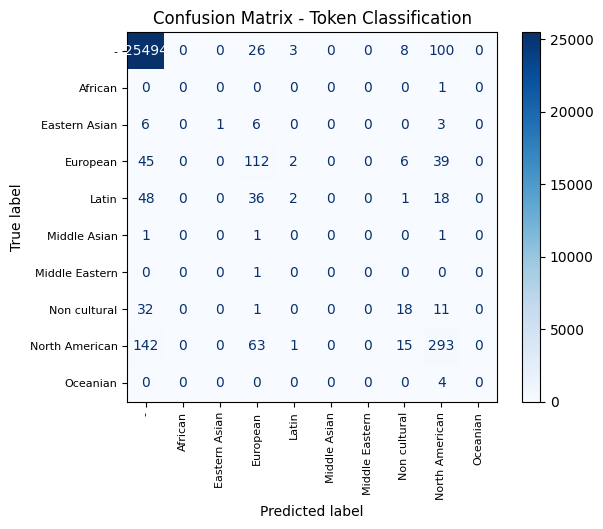

In [35]:
# Use list comprehension for better performance
true_labels = [l for pred, label in zip(preds_fun, labels_fun) for p, l in zip(pred, label) if l != -100]
pred_labels = [p for pred, label in zip(preds_fun, labels_fun) for p, l in zip(pred, label) if l != -100]

# Confusion Matrix Calculation
cm = confusion_matrix(true_labels, pred_labels, labels=list(range(len(id2tag_cultural))))

# Mapping labels
all_labels = list(id2tag_cultural.values())

# Plotting the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=all_labels)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Token Classification")
plt.xticks(fontsize=8, rotation=90)
plt.yticks(fontsize=8)
plt.show()

In [36]:
cm = confusion_matrix(true_labels, pred_labels, labels=list(range(len(id2tag_cultural))))
cm

array([[25494,     0,     0,    26,     3,     0,     0,     8,   100,
            0],
       [    0,     0,     0,     0,     0,     0,     0,     0,     1,
            0],
       [    6,     0,     1,     6,     0,     0,     0,     0,     3,
            0],
       [   45,     0,     0,   112,     2,     0,     0,     6,    39,
            0],
       [   48,     0,     0,    36,     2,     0,     0,     1,    18,
            0],
       [    1,     0,     0,     1,     0,     0,     0,     0,     1,
            0],
       [    0,     0,     0,     1,     0,     0,     0,     0,     0,
            0],
       [   32,     0,     0,     1,     0,     0,     0,    18,    11,
            0],
       [  142,     0,     0,    63,     1,     0,     0,    15,   293,
            0],
       [    0,     0,     0,     0,     0,     0,     0,     0,     4,
            0]], dtype=int64)

#### Classification evaluation

In [ ]:
true_labels_flat = []
pred_labels_flat = []

for true_seq, pred_seq in zip(outputs_fun.label_ids, preds_fun):
    for true_label, pred_label in zip(true_seq, pred_seq):
        if true_label != -100:
            true_tag = id2tag_cultural[true_label]
            pred_tag = id2tag_cultural[pred_label]
            
            if true_tag != "-":
                true_labels_flat.append(true_tag)
                pred_labels_flat.append(pred_tag)

print(classification_report(true_labels_flat, pred_labels_flat))


                precision    recall  f1-score   support

             -       0.00      0.00      0.00         0
       African       0.00      0.00      0.00         1
 Eastern Asian       1.00      0.06      0.12        16
      European       0.51      0.55      0.53       204
         Latin       0.40      0.02      0.04       105
  Middle Asian       0.00      0.00      0.00         3
Middle Eastern       0.00      0.00      0.00         1
  Non cultural       0.45      0.29      0.35        62
North American       0.79      0.57      0.66       514
      Oceanian       0.00      0.00      0.00         4

      accuracy                           0.47       910
     macro avg       0.32      0.15      0.17       910
  weighted avg       0.66      0.47      0.52       910



#### Training loss and learning rate

In [39]:
def plot_training_logs_from_json(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)

    logs = data["log_history"]

    steps_loss = []
    train_loss = []
    lr = []

    steps_f1 = []
    eval_f1 = []

    steps_eval_loss = []
    eval_loss = []

    for log in logs:
        if "loss" in log:
            steps_loss.append(log["step"])
            train_loss.append(log["loss"])
            lr.append(log.get("learning_rate", float('nan')))

        if "eval_f1" in log:
            steps_f1.append(log["step"])
            eval_f1.append(log["eval_f1"])

        if "eval_loss" in log:
            steps_eval_loss.append(log["step"])
            eval_loss.append(log["eval_loss"])

    # Plotting
    fig, axs = plt.subplots(4, 1, figsize=(10, 16), sharex=True)

    axs[0].plot(steps_loss, train_loss, color='blue', label='Training Loss')
    axs[0].set_ylabel("Loss")
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(steps_loss, lr, color='green', linestyle='--', label='Learning Rate')
    axs[1].set_ylabel("Learning Rate")
    axs[1].legend()
    axs[1].grid(True)

    axs[2].plot(steps_f1, eval_f1, color='purple', label='Eval F1 Score')
    axs[2].set_ylabel("F1 Score")
    axs[2].legend()
    axs[2].grid(True)

    axs[3].plot(steps_eval_loss, eval_loss, color='red', label='Eval Loss')
    axs[3].set_xlabel("Step")
    axs[3].set_ylabel("Eval Loss")
    axs[3].legend()
    axs[3].grid(True)

    plt.tight_layout()
    plt.show()


In [42]:
trainer_state_path_3 = "xlmr-cultural-3/checkpoint-1200/trainer_state.json"

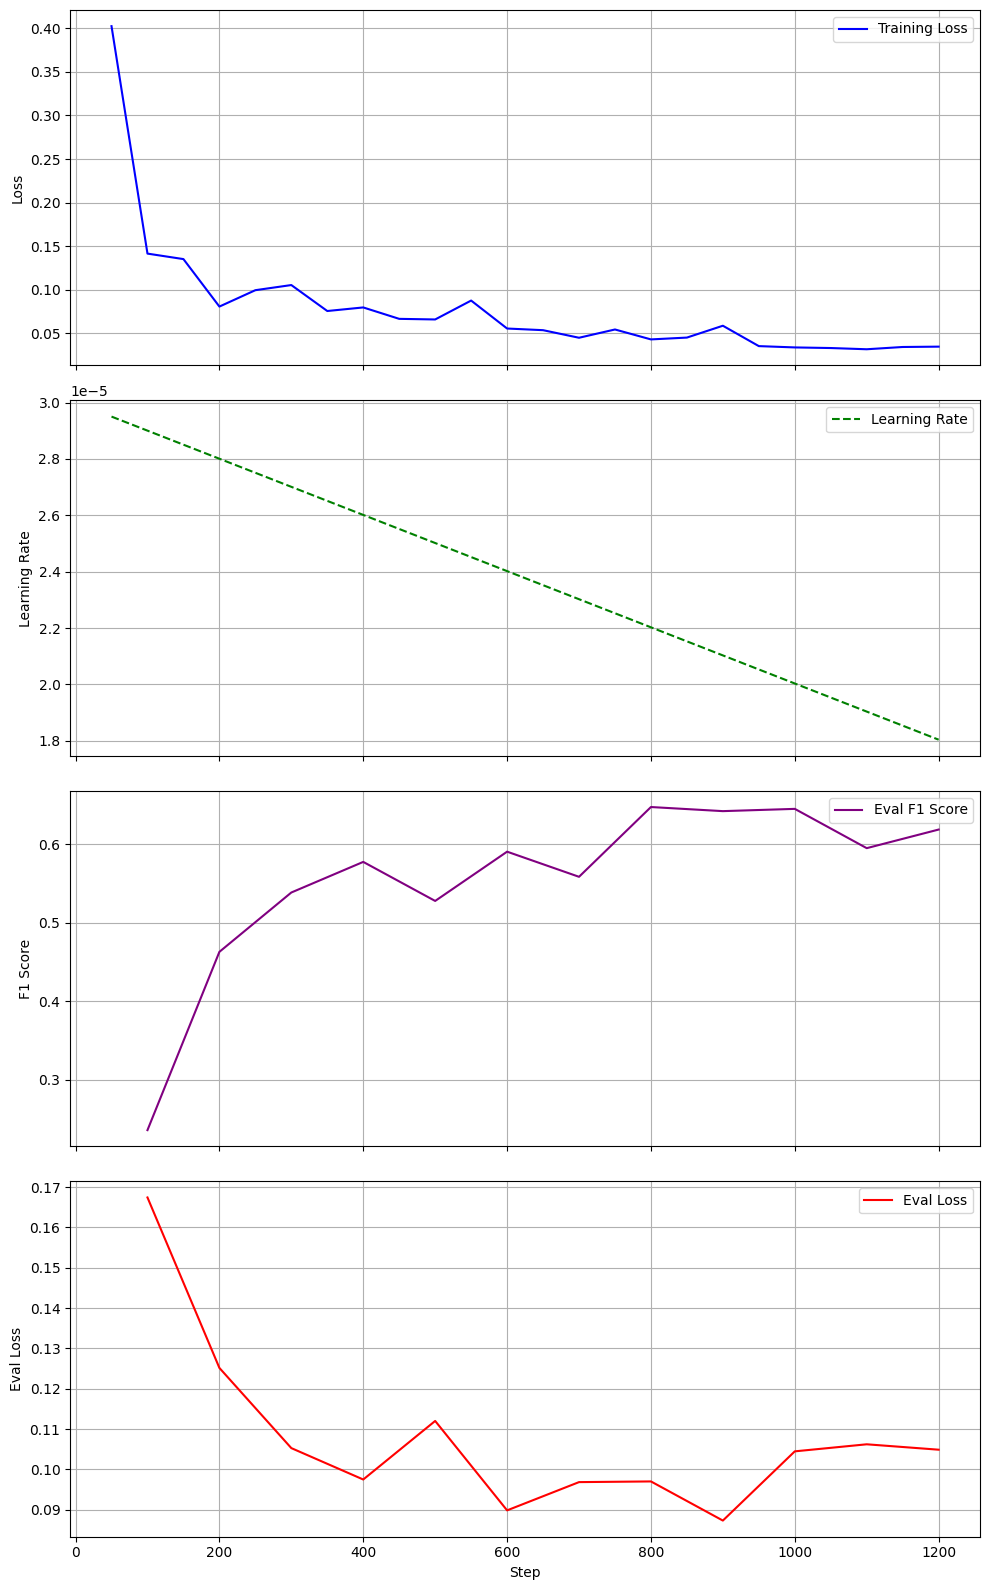

In [43]:
plot_training_logs_from_json(trainer_state_path_3)